# Regression Analysis

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import OLSInfluence, variance_inflation_factor

## 1. 단일회귀분석

### 1) Load Data

In [6]:
url = 'https://raw.githubusercontent.com/rusita-ai/pyData/master/Galton.txt'

DF = pd.read_table(url)

DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 898 entries, 0 to 897
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Family  898 non-null    object 
 1   Father  898 non-null    float64
 2   Mother  898 non-null    float64
 3   Gender  898 non-null    object 
 4   Height  898 non-null    float64
 5   Kids    898 non-null    int64  
dtypes: float64(3), int64(1), object(2)
memory usage: 42.2+ KB


In [7]:
DF.head()

,Family,Father,Mother,Gender,Height,Kids
0,1,78.5,67.0,M,73.2,4
1,1,78.5,67.0,F,69.2,4
2,1,78.5,67.0,F,69.0,4
3,1,78.5,67.0,F,69.0,4
4,2,75.5,66.5,M,73.5,4


### 3) 남자 데이터만 분리

In [8]:
DFS = DF.loc[DF.Gender == 'M' , : ]
DFS.head()

,Family,Father,Mother,Gender,Height,Kids
0,1,78.5,67.0,M,73.2,4
4,2,75.5,66.5,M,73.5,4
5,2,75.5,66.5,M,72.5,4
8,3,75.0,64.0,M,71.0,2
10,4,75.0,64.0,M,70.5,5


### 3) pearson 상관계수

In [9]:
stats.pearsonr(DFS.Father, DFS.Height)[0]

0.3913173581417901

### 4) 회귀선 시각화

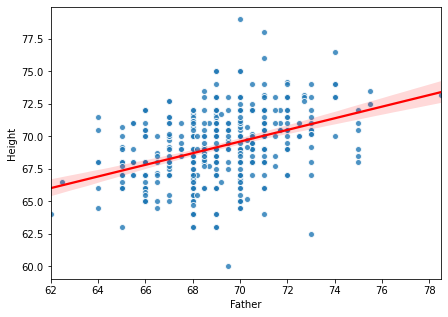

In [10]:
plt.figure(figsize = (7, 5))
sns.regplot(x = DFS.Father, y = DFS.Height,
            line_kws = {'color' : 'red'},
            scatter_kws = {'edgecolor' : 'white'})
plt.show()

### 5) Modeling

In [11]:
Model_lm = smf.ols(formula = 'Height ~ Father' ,
                   data = DFS).fit()

### 6) Model Summary
- 잔차(residual) 검증
  - Prob(Omnibus) & Prob(JB): 0.05보다 크면 정규분포
  - 왜도(Skew): 정규분포는 '0' , '0'보다 크면 오른쪽 자락이 길어짐
  - 첨도(Kurtosis): 정규분포는 '3'
  - Durbin-Watson: 잔파의 자기상관 체크 지표 '2' 전후

In [12]:
Model_lm.summary(alpha = 0.05)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Height   R-squared:                       0.153
Model:                            OLS   Adj. R-squared:                  0.151
Method:                 Least Squares   F-statistic:                     83.72
Date:                Sun, 14 Mar 2021   Prob (F-statistic):           1.82e-18
Time:                        12:53:38   Log-Likelihood:                -1070.6
No. Observations:                 465   AIC:                             2145.
Df Residuals:                     463   BIC:                             2153.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     38.2589      3.387     11.297      0.000      31.604      44.914
Father         0.4477      0.049      9.150      0.000       0.352       0.544
==============================================================================
Omnibus:                        8.699   Durbin-Watson:                   1.481
Prob(Omnibus):                  0.013   Jarque-Bera (JB):               13.007
Skew:                          -0.112   Prob(JB):                      0.00150
Kurtosis:                       3.788   Cond. No.                     2.09e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.09e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## 2. 모델의 선형성

### 1) 예측값(fitted) 계산

In [13]:
fitted = Model_lm.predict(DFS.Father)

### 2) 잔차(residual) 계산
- 실제값과 예측값의 차이

In [14]:
residual = DFS.Height - fitted

### 3) 예측값과 잔차 비교
- 모든 예측값에서 잔차가 비슷하게 있어야 함
- 잔차의 추세: 빨간 실선
- 빨간 실선이 회색 점선을 크게 벗어난다면 예측값에 따라 잔차가 크게 달라지는 것을 의미

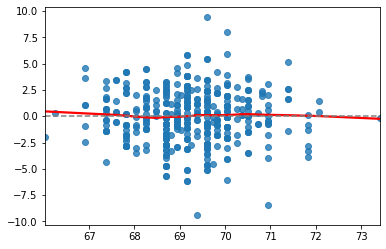

In [15]:
sns.regplot(fitted, residual,
            lowess = True,
            line_kws = {'color' : 'red'})
plt.plot([fitted.min() , fitted.max()],
         [0, 0], '--' , color = 'gray')
plt.show()

## 3. 잔차분석

### 1) 잔차의 정규성
- 잔차가 정규분포를 따른다는 가정 검증

In [16]:
sr = stats.zscore(residual)
(x, y) , _ = stats.probplot(sr)

- Q-Q 플롯
  - 잔차가 정규분포를 띄면 Q-Q플롯에서 점들이 점선을 따라 배치

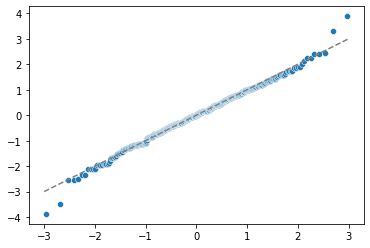

In [17]:
sns.scatterplot(x, y)
plt.plot([-3, 3] , [-3, 3] , '--' , color = 'gray')
plt.show()

- shapiro Test
  - p값이 0.05보다 작아 잔차의 정규성을 따른다는 귀무가설을 기각
  - 유의수준 5%에서 잔차의 정규성 위반


In [18]:
stats.shapiro(residual)[1]

0.04990636184811592

- Residual Visualization

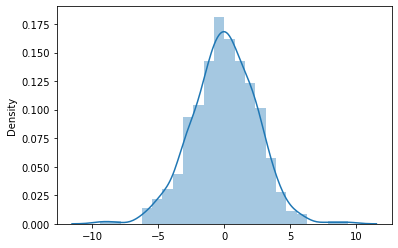

In [19]:
sns.distplot(residual)
plt.show()

### 2) 잔차의 등분산성
- 예측된 값이 크든 작든, 모든 값들에 대하여 잔차의 분산이 동일하다는 가정
  - 예측값(가로축)에 따라 잔차가 어떻게 달라지는지 시각화
  - 빨간실선이 수평선을 그리는 것이 이상적

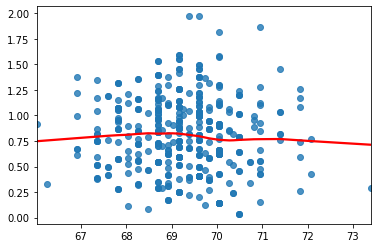

In [20]:
sns.regplot(fitted,
            np.sqrt(np.abs(sr)),
            lowess = True,
            line_kws = {'color' : 'red'})
plt.show()

### 3) 잔차의 독립성
- 회귀분석에서 잔차는 정규성, 등분산성 그리고 독립성을 가지는 것으로 가정
- 자료수집 시 Random Sampling을 하였다면, 잔차의 독립성은 만족하는 것으로 봄

### 4) 극단값
- Cook's distance
  - 극단값을 나타내는 지표

In [21]:
cd, _ = OLSInfluence(Model_lm).cooks_distance

- 59번 자료가 예측에서 많이 벗어남을 확인

In [22]:
cd.sort_values(ascending = False).head()

59     0.050149
22     0.026499
868    0.023930
17     0.020738
125    0.019052
dtype: float64

## 4. 다중회귀분석

### 1) Load Data

In [23]:
DF2 = sns.load_dataset('iris')

DF2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


In [24]:
DF2.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


### 2) pearson 상관계수

In [25]:
DF2.corr()

,sepal_length,sepal_width,petal_length,petal_width
sepal_length,1.000000,-0.117570,0.871754,0.817941
sepal_width,-0.117570,1.000000,-0.428440,-0.366126
petal_length,0.871754,-0.428440,1.000000,0.962865
petal_width,0.817941,-0.366126,0.962865,1.000000


### 3) Visualization

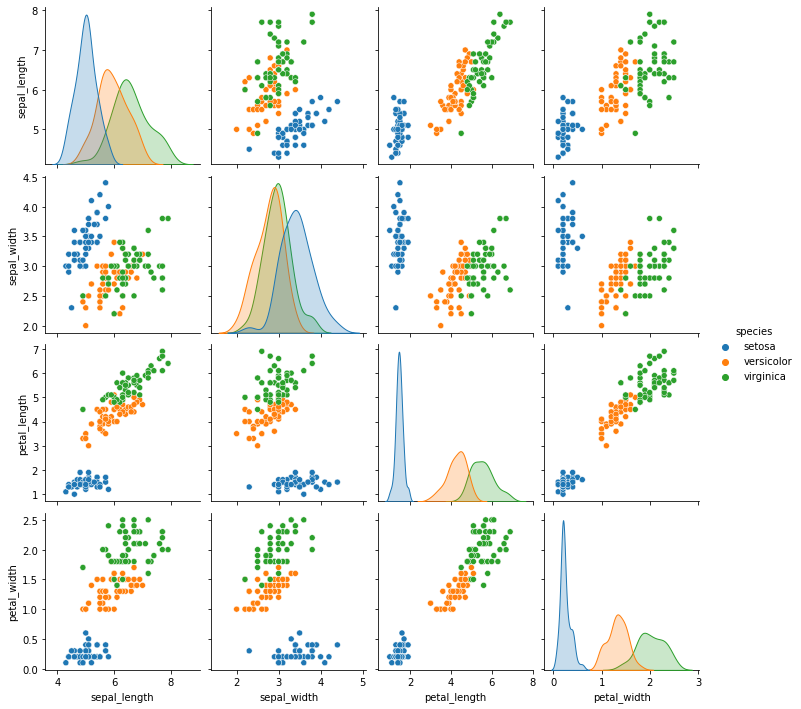

In [26]:
sns.pairplot(hue = 'species' , data = DF2)
plt.show()

### 4) Modeling

In [27]:
Model = smf.ols(formula = 'sepal_length ~ sepal_width + petal_length + petal_width' ,
                data = DF2)

In [28]:
Model_mr = Model.fit()

### 5) Model Summary

In [29]:
Model_mr.summary(alpha = 0.05)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           sepal_length   R-squared:                       0.859
Model:                            OLS   Adj. R-squared:                  0.856
Method:                 Least Squares   F-statistic:                     295.5
Date:                Sun, 14 Mar 2021   Prob (F-statistic):           8.59e-62
Time:                        12:53:47   Log-Likelihood:                -37.321
No. Observations:                 150   AIC:                             82.64
Df Residuals:                     146   BIC:                             94.69
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        1.8560      0.251      7.401      0.000       1.360       2.352
sepal_width      0.6508      0.067      9.765      0.000       0.519       0.783
petal_length     0.7091      0.057     12.502      0.000       0.597       0.821
petal_width     -0.5565      0.128     -4.363      0.000      -0.809      -0.304
==============================================================================
Omnibus:                        0.345   Durbin-Watson:                   2.060
Prob(Omnibus):                  0.842   Jarque-Bera (JB):                0.504
Skew:                           0.007   Prob(JB):                        0.777
Kurtosis:                       2.716   Cond. No.                         54.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 5. 다중공선성(Multicollinearity)
- 공선성(Collinearity): 독립변수가 다른 독립변수로 잘 예측되는 경우
  - 또는 서로 상관이 높은 경우
- 다중공선성(Multicollinearity): 독립변수가 다른 여러 개의 독립변수들로 잘 예측되는 경우

### 1) 독립변수 확인

In [31]:
Model.exog_names

['Intercept', 'sepal_width', 'petal_length', 'petal_width']

### 2) 다중공선성 진단
- 분산 팽창계수(VIF: Variance Inflation Factor)
  - 엄밀한 기준은 없으나 보통 10보다 크면 다중공선성이 있다고 판단
  - 5을 기준으로 하기도 함
- 'sepal_width'의 VIF

In [32]:
variance_inflation_factor(Model.exog, 1)

1.270814929344654

- 'petal_length'의 VIF

In [33]:
variance_inflation_factor(Model.exog, 2)

15.097572322915717

- 'petal_width'의 VIF

In [34]:
variance_inflation_factor(Model.exog, 3)

14.234334971742083

- pearson 상관계수

In [35]:
DF2.corr()

,sepal_length,sepal_width,petal_length,petal_width
sepal_length,1.000000,-0.117570,0.871754,0.817941
sepal_width,-0.117570,1.000000,-0.428440,-0.366126
petal_length,0.871754,-0.428440,1.000000,0.962865
petal_width,0.817941,-0.366126,0.962865,1.000000


### 3) 다중공선성 해결
- VIF가 큰 독립변수를 제거 후 리모델링
  - 'petal_width' 제거

In [37]:
Model_VIF = smf.ols(formula = 'sepal_length ~ sepal_width + petal_length' ,
                    data = DF2).fit()

- 다중공선성 처리 후

In [38]:
Model_VIF.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           sepal_length   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     386.4
Date:                Sun, 14 Mar 2021   Prob (F-statistic):           2.93e-59
Time:                        13:09:37   Log-Likelihood:                -46.513
No. Observations:                 150   AIC:                             99.03
Df Residuals:                     147   BIC:                             108.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        2.2491      0.248      9.070      0.000       1.759       2.739
sepal_width      0.5955      0.069      8.590      0.000       0.459       0.733
petal_length     0.4719      0.017     27.569      0.000       0.438       0.506
==============================================================================
Omnibus:                        0.164   Durbin-Watson:                   2.021
Prob(Omnibus):                  0.921   Jarque-Bera (JB):                0.319
Skew:                          -0.044   Prob(JB):                        0.853
Kurtosis:                       2.792   Cond. No.                         48.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""